# Семинар 3. kNN модели. Кастомный kNN. 

In [39]:
import requests
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from tqdm.auto import tqdm
import warnings
import dill
from implicit.nearest_neighbours import CosineRecommender
from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import MAP, AvgRecPopularity, MeanInvUserFreq, calc_metrics

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.float_format', lambda x: f'{x:,.6f}')

# Датасет KION 

In [4]:
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'
req = requests.get(url, stream=True)

with open('kion_train.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='Downloading the kion dataset...', 
                        total=total_size_in_bytes, 
                        unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

In [10]:
!unzip kion_train.zip -x '__MACOSX/*'
!rm kion_train.zip

unzip:  cannot find or open kion_train.zip, kion_train.zip.zip or kion_train.zip.ZIP.
rm: kion_train.zip: No such file or directory


## EDA

In [4]:
interactions = pd.read_csv('data_original/interactions.csv')
interactions = interactions.rename(columns={'total_dur': Columns.Weight, 
                                            'last_watch_dt': Columns.Datetime})
interactions['datetime'] = pd.to_datetime(interactions['datetime'])

users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

## interactions

In [12]:
pd.concat([interactions.head(), interactions.tail()])

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.000000
1,699317,1659,2021-05-29,8317,100.000000
2,656683,7107,2021-05-09,10,0.000000
3,864613,7638,2021-07-05,14483,100.000000
4,964868,9506,2021-04-30,6725,100.000000
5476246,648596,12225,2021-08-13,76,0.000000
5476247,546862,9673,2021-04-13,2308,49.000000
5476248,697262,15297,2021-08-20,18307,63.000000
5476249,384202,16197,2021-04-19,6203,100.000000
5476250,319709,4436,2021-08-15,3921,45.000000


In [13]:
print(f"Interactions dataframe shape: {interactions.shape}")
print(f"Unique users in interactions: {interactions['user_id'].nunique():_}")
print(f"Unique items in interactions: {interactions['item_id'].nunique():_}")

Interactions dataframe shape: (5476251, 5)
Unique users in interactions: 962_179
Unique items in interactions: 15_706


In [14]:
max_date = interactions['datetime'].max()
min_date = interactions['datetime'].min()

print(f"min date in interactions: {min_date}")
print(f"max date in interactions: {max_date}")

min date in interactions: 2021-03-13 00:00:00
max date in interactions: 2021-08-22 00:00:00


## users

In [15]:
pd.concat([users.head(), users.tail()])

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0
840196,166555,age_65_inf,income_20_40,Ж,0


In [16]:
print(f"Users dataframe shape {users.shape}")
print(f"Unique users: {users['user_id'].nunique():_}")

Users dataframe shape (840197, 5)
Unique users: 840_197


## items

In [17]:
pd.concat([items.head(2), items.tail(2)])

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,"2,002.000000","драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.000000,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Грандинетти, Джеральдин Чаплин, Елена Анайя, Каэтано Велозо, Леонор Уотлинг, Лола Дуэньяс, Лолес Леон, Малу Айродо, Мариола Фуэнтес, Пас Вега, Пина Бауш, Ро...",Мелодрама легендарного Педро Альмодовара «Поговори с ней» в 2003 году получила премию «Оскар» за лучший сценарий. Журналист Марко берет интервью у знаменитой женщины-тореро Лидии и вскоре влюбляе...,"Поговори, ней, 2002, Испания, друзья, любовь, сильные, женщины, преодоление, трудностей, отношения, дружба, отношения, паре, отношения, мужчины, женщины, романтические, отношения, потеря, близких,..."
1,2508,film,Голые перцы,Search Party,"2,014.000000","зарубежные, приключения, комедии",США,NaN,16.000000,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон Манцукас, Джон Глейсер, Карл Грин, Кристен Риттер, Лэнс Реддик, Морис Комт, Патрик Кернс, Ребекка Коллинз, Роза Салазар, Росс П. Кук, Стеффи Гроут, Ти...","Уморительная современная комедия на популярную тему о том, как не надо отмечать мальчишник. Главный герой усвоил, что не надо звать на свадьбу своего друга Джейсона, из-за которого он вместо сваде...","Голые, перцы, 2014, США, друзья, свадьбы, преодоление, трудностей, расставания, отношения, дружба, риск, недоразумение, мужская, дружба, мальчишники, девичники"
15961,4538,series,Среди камней,Darklands,"2,019.000000","драмы, спорт, криминал",Россия,0.000000,18.000000,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родди, Марк О’Халлоран, Джимми Смоллхорн","Семнадцатилетний Дэмиен мечтает вырваться за пределы своего района и стать профессиональным бойцом. Когда его кумир и старший брат исчезает, парень попадает в чуждый ему мир насилия, наркотиков и ...","Среди, камней, 2019, Россия"
15962,3206,series,Гоша,NaN,"2,019.000000",комедии,Россия,0.000000,16.000000,NaN,Михаил Миронов,"Мкртыч Арзуманян, Виктория Рунцова","Добродушный Гоша не может выйти из дома, чтобы не попасть в нелепую и курьёзную историю. Но даже неудачники мечтают о любви, и наш герой — не исключение, ведь оптимизма ему не занимать.","Гоша, 2019, Россия"


In [18]:
print(f"Items dataframe shape {items.shape}")
print(f"Unique item_id: {items['item_id'].nunique():_}")

Items dataframe shape (15963, 14)
Unique item_id: 15_963


##  Train test split 

In [40]:
max_date = interactions['datetime'].max()

train = interactions[(interactions['datetime'] <= max_date - pd.Timedelta(days=7))]
test = interactions[(interactions['datetime'] > max_date - pd.Timedelta(days=7))]

# оставляем только теплых пользователей в тесте
test = test[test['user_id'].isin(train['user_id'].unique())]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (5051815, 5)
test: (306752, 5)


# Сделаем c нуля новый алгоритм: перейдем от модели itemkNN к модели userkNN

## 1.  train matrix 

### 1.1 Сделаем `user` и `item` mappings

users_mapping = `{user0: 0, user1: 1, ... , userN: N}`

items_mapping = `{item0: 0, item1: 1, ... , itemK: K}`

Вопрос: зачем нам нужны эти маппинги?

In [41]:
users_inv_mapping = dict(enumerate(train['user_id'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}

In [42]:
items_inv_mapping = dict(enumerate(train['item_id'].unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}

In [43]:
print(f"users_mapping amount: {len(users_mapping)}")
print(f"items_mapping amount: {len(items_mapping)}")

users_mapping amount: 906071
items_mapping amount: 15577


### 1.2. Сформируем sparse matrix 

Чтение про sparse матрицы https://matteding.github.io

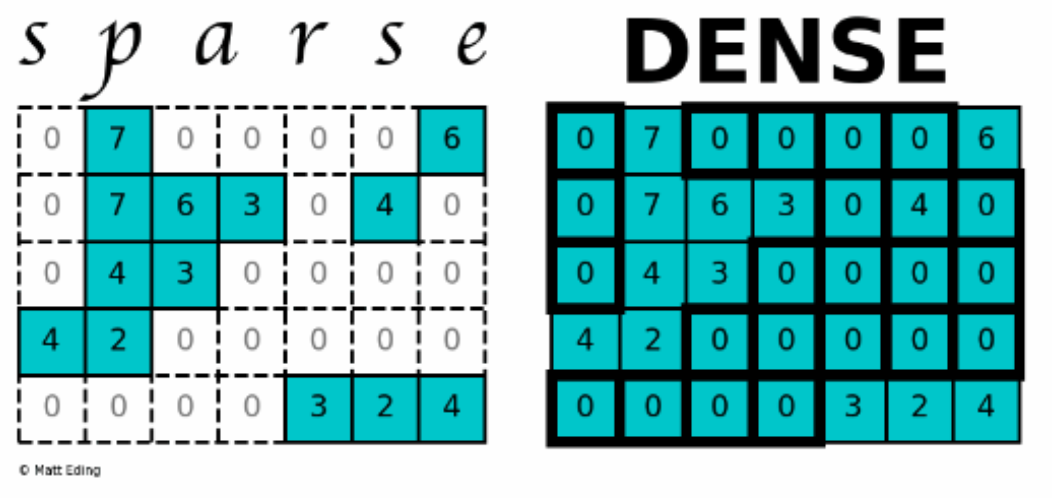

In [44]:
def get_coo_matrix(df, user_col='user_id', item_col='item_id',
                   weight_col=None, users_mapping=None, items_mapping=None):
    """
    Creates a sparse interaction matrix (COO format) between users and items.
    """
    if users_mapping is None or items_mapping is None:
        raise ValueError("Both users_mapping and items_mapping must be provided.")
    
    if weight_col and weight_col in df.columns:
        weights = df[weight_col].astype(np.float32).values
    else:
        weights = np.ones(len(df), dtype=np.float32)
    
    user_idx = df[user_col].map(users_mapping.get).dropna().astype(int)
    item_idx = df[item_col].map(items_mapping.get).dropna().astype(int)
    
    return coo_matrix((weights, (user_idx, item_idx)))

In [45]:
user_item_matrix = get_coo_matrix(train, weight_col='weight',
                                users_mapping=users_mapping, 
                                items_mapping=items_mapping)

In [46]:
# проверяем размерность матрицы
user_item_matrix

<906071x15577 sparse matrix of type '<class 'numpy.float32'>'
	with 5051815 stored elements in COOrdinate format>

## 2. Как бы обучалась `itemkNN` модель 

У нас классическая `interaction_matrix = users x items`

Когда мы обучаем классический implicit itemkNN и получаем соседей `items`, то мы передаем матрицу `user-item` 
(так исторически сложилось в implicit):
 
`model.fit(interaction_matrix)`

In [47]:
# K : int, optional
# The number of neighbours to include when calculating the similarity matrix

# fit за 1 мин (5 CPU)
itemknn = CosineRecommender(K=30)
itemknn.fit(user_item_matrix)

  0%|          | 0/15577 [00:00<?, ?it/s]

## 2. Обучим `UserkNN` модель 

Так как мы хотим обучить `userknn` и получить **user** neighbours, то мы просто передаем ее в алгоритм транспонированную: `model.fit(user_item_matrix.T)`. 

Если бы мы делали itemkNN, то передавали бы матрицу как `model.fit(interaction_matrix.T)` 

(применимо для модели implicit.nearest_neighbours.ItemItemRecommender)

### Оцените как долго идет обучение


- потому что обучаемся в разрезе 896791 эмбеддингов юзеров (потому что хотим UserKnn)
- если бы искали соседей у айтемов, то цикл был бы для 15565 эмбеддингов айтемов - что значительно быстрее



In [31]:
# fit за 25 мин (5 CPU)
userknn = CosineRecommender(K=30)
userknn.fit(user_item_matrix.T)

  0%|          | 0/906071 [00:00<?, ?it/s]

In [49]:
# save model
with open('userknn.dill', 'wb') as f:
    dill.dump(userknn, f)

In [48]:
with open('userknn.dill', 'rb') as f:
    userknn = dill.load(f)

## 3. Реализуем метод Recommend чтобы получить user neighbours

In [49]:
# example of similar users to user with internal id = 1 
userknn.similar_items(1)

(array([     1, 833074, 126319, 457517,  50968, 367465, 892196, 790274,
        793106, 828548], dtype=int32),
 array([1.00000001, 0.36483897, 0.36044331, 0.35847579, 0.35574781,
        0.35391451, 0.35391451, 0.35391451, 0.35391451, 0.35391451]))

In [17]:
def generate_implicit_recs_mapper(model, N_similar_users, users_mapping=None, 
                                  users_inv_mapping=None):
    def _recs_mapper(user):
        user_id = users_mapping[user]
        users, similarity = model.similar_items(user_id, N=N_similar_users)
        return [users_inv_mapping[user] for user in users], similarity
    return _recs_mapper

In [50]:
mapper = generate_implicit_recs_mapper(
    userknn, 
    N_similar_users=30,
    users_mapping=users_mapping,
    users_inv_mapping=users_inv_mapping
)

### 3.1 Получим соседей пользователей из теста и меру близости

In [51]:
recs = pd.DataFrame({
    'user_id': test['user_id'].unique()
})

recs['similar_user_id'], recs['similarity'] = zip(*recs['user_id'].map(mapper))

# посмотрим на 5 рандомных пользователей
recs[recs['user_id'].isin(np.random.choice(test['user_id'], 5))]

,user_id,similar_user_id,similarity
26910,133773,"[468239, 631480, 224467, 931167, 617902, 347674, 336010, 266494, 82372, 813859, 414909, 596218, 781481, 962027, 290667, 275805, 933452, 788589, 804908, 739847, 71798, 218721, 147114, 695822, 22656...","[1.0000000297877771, 1.0000000297877771, 1.0000000297877771, 1.0000000297877771, 1.000000029758716, 1.000000029758716, 1.000000029758716, 1.0000000297296971, 1.0000000297296971, 1.0000000297296971..."
33083,878057,"[878057, 191646, 447105, 330253, 128275, 874609, 3943, 150107, 688966, 877296, 366801, 387301, 325251, 686136, 409153, 735846, 482128, 1072769, 619956, 487252, 100590, 288604, 413065, 488571, 4216...","[1.000000041918021, 0.9982057270541209, 0.9801327997292706, 0.8001563671242372, 0.8001563644641887, 0.8001563630933893, 0.8001563620099502, 0.8001563598347416, 0.8001563589251053, 0.80015635764034..."
51993,339793,"[339793, 973383, 73007, 844514, 708809, 603, 244586, 736930, 1037611, 121500, 720483, 168424, 522158, 42951, 50289, 157744, 869713, 116818, 200250, 57544, 870535, 1033943, 139490, 667815, 171037, ...","[1.0000000159113416, 0.709180248799367, 0.7033775534447774, 0.6531962174171586, 0.6487289948338693, 0.6461440858609901, 0.6340173168496037, 0.6340164329949928, 0.6340163994913398, 0.63401470996841..."
59658,199321,"[1044329, 294552, 2110, 557115, 1010529, 895623, 537097, 318347, 584019, 79321, 645348, 695269, 396111, 803508, 1064560, 361019, 704247, 890143, 486383, 827442, 982010, 786028, 164489, 941182, 664...","[1.000000029299461, 1.0000000287953938, 1.0000000287401907, 1.0000000279308385, 1.0000000267052245, 1.0000000260271777, 1.000000025885244, 1.00000002562803, 1.000000024592889, 1.0000000245493135, ..."
70101,285430,"[285430, 303438, 298254, 230817, 877543, 928609, 417316, 574099, 103366, 970517, 809911, 486262, 235930, 247397, 184539, 754138, 223684, 412820, 1012935, 949769, 1018216, 739801, 783589, 45054, 64...","[1.0000000114301801, 0.8686090820785994, 0.7526955547791536, 0.7504781680579906, 0.7498484129938323, 0.7189517186907339, 0.7053861976580095, 0.7042783035507794, 0.7035812333251916, 0.7012513047888..."


### 3.2 Развернем списки для вертикального представления

In [52]:
recs = (
    recs
    .set_index('user_id')                # cтавим user_id в индекс
    .apply(pd.Series.explode)            # разворачиваем списки в столбцах
    .reset_index()                       # возвращаемся к обычному индексу
    .assign(similar_user_id=lambda df: df['similar_user_id'].astype(int))  # приводим к int
    .query('user_id != similar_user_id') # удаляем рекомендации самого себя
)

In [53]:
recs[recs['user_id'].isin(np.random.choice(test['user_id'], 5))]

,user_id,similar_user_id,similarity
63491,318229,1078788,0.628850
63492,318229,951879,0.627956
63493,318229,43746,0.619471
63494,318229,480908,0.596849
63495,318229,441735,0.583126
...,...,...,...
1820525,580306,672663,0.994382
1820526,580306,146542,0.994382
1820527,580306,276448,0.994382
1820528,580306,39940,0.994382


## 4. Как получить рекомендации в таком алгоритме? Рекомендуем пользователю просмотренные фильмы его ближайших соседей 

- Соберем просмотренные айтемы для каждого юзера
- приджоиним их по similar_user_id к исходному списку пользователей

In [54]:
watched = train\
    .groupby('user_id', as_index=False)\
    .agg({'item_id': list})\
    .rename(columns={'user_id': 'similar_user_id'})

watched.head()

,similar_user_id,item_id
0,0,"[7102, 14359, 15297, 6006, 9728, 12192]"
1,1,[10440]
2,2,"[7571, 3541, 15266, 13867, 12841, 10770, 4475, 9506, 8936, 11018, 11577, 561, 7106, 6774, 16029, 8482, 6825, 3594, 16166, 5819, 2954, 383, 11689, 12449, 2025, 6155, 3628, 334, 4024, 7210, 11539, 1..."
3,3,"[12192, 9728, 16406, 15719, 10440, 3475, 4151, 1418, 2220, 3734, 6208, 13789, 8581, 13849, 9550, 10464, 4880, 4436, 142, 8801, 11790, 2657, 8252]"
4,4,"[4700, 6317]"


In [55]:
recs = (recs
    .merge(watched, on=['similar_user_id'], how='left')  # джойним просмотренные айтемы  
    .explode('item_id')  # разворачиваем списки
    .sort_values(['user_id', 'similarity'], ascending=False)  # cортируем по убыванию similarity
    .drop_duplicates(['user_id', 'item_id'], keep='first')  # даляем дубли (оставляем item_id с максимальной similarity)
)

## Получается, что для одного user_id и его рекомендованных item_id, пришедших от одного и того же соседа мы имеем одну и ту же меру похожести (similarity) просто потому, что так работает алгоритм. Давайте это исправим на следующем шаге

In [56]:
recs[recs['user_id'].isin(np.random.choice(test['user_id'], 5))]

,user_id,similar_user_id,similarity,item_id
401415,987008,1060750,0.997868,747
401415,987008,1060750,0.997868,9728
401418,987008,520667,0.987175,8036
2043331,918005,64932,0.913354,16228
2043331,918005,64932,0.913354,13073
...,...,...,...,...
2532752,28759,275772,0.731250,6171
2532753,28759,74631,0.723442,11345
2532754,28759,460401,0.722283,7019
2532754,28759,460401,0.722283,12360


## 5. Изобретаем rank из поля similarity

Вдохновимся статьей Effective Nearest-Neighbor Music Recommendations

В статье описывается задача так называемого “playlist continuation”: как автоматически подобрать треки для продолжения незавершённого плейлиста, имея лишь некоторую исходную информацию о нём (название, несколько добавленных пользователем песен и т.п.). Этот челлендж проводился в рамках ACM RecSys Challenge 2018, где участники должны были предложить алгоритмы, максимально точно восстанавливающие скрытые треки плейлистов из большого датасета от Spotify (Million Playlist Dataset)

У них в статье - плейлисты и треки, у нас - пользователи и фильмы, но идея та же: как продолжить список фильмов для пользователя, имея информацию о его просмотренных фильмах и фильмах его ближайших соседей. 

Ключевым элементом стала корректировка весов треков, а также использование IDF (inverse document frequency), чтобы не перетягивать рекомендации в сторону слишком популярных песен

![image.png](https://i.ibb.co/yBM6jXqq/similarity-tf-idf.png)



https://web-ainf.aau.at/pub/jannach/files/Workshop_RecSys_Challenge_2018.pdf

### 5.1 посчитаем `idf` для каждого item

- `n` - кол-во рекомендаций = кол-во пользователей
- `document frequency (= recommendation list frequency) of the item` = кол-во раз, когда item встречается в датафрейме с рекомендациями

### Вывод по формуле для rank

- `idf` больше для `непопулярных` айтемов 
- в случае одинаковых занчений similarity получаем, что мы ранжируем наверх менее популярные айтемы (внутри одного юзера), что позволяет бороться со знаменитым смещением в популярное 

![image.png](https://i.ibb.co/fzpghYpC/tf-idf.png)

In [60]:
from collections import Counter

cnt = Counter(train['item_id'].values)
n = train.shape[0]

idf = (
    pd.DataFrame
    .from_dict(cnt, orient='index', columns=['df'])  # конвертируем Counter в DataFrame
    .reset_index()                                    
    .assign(                                         # добавляем столбец idf
        idf=lambda df: np.log((1 + n) / (1 + df['df']) + 1)
    )
)

idf.head()

,index,df,idf
0,9506,3858,7.177859
1,1659,985,8.541797
2,7107,16279,5.740783
3,7638,1153,8.384497
4,6686,2060,7.804720


In [61]:
# join idf 
recs = recs\
    .merge(
        idf[['index', 'idf']], 
        left_on='item_id',
        right_on='index',
        how='left')\
    .drop(['index'], axis=1)

# apply formula from an article 
recs['rank_idf'] = recs['similarity'] * recs['idf']

recs[recs['user_id'] == 1097544]

,user_id,similar_user_id,similarity,item_id,idf_x,rank_idf,idf_y,idf
0,1097544,412291,0.704641,8636,5.003507,3.525675,5.003507,5.003507
1,1097544,412291,0.704641,7829,5.636214,3.971507,5.636214,5.636214
2,1097544,412291,0.704641,9996,4.958866,3.494219,4.958866,4.958866


In [62]:
# make order by rank_idf 
recs = recs.sort_values(['user_id', 'rank_idf'], ascending=False)

# make rank
recs['rank'] = recs.groupby('user_id').cumcount() + 1 

recs[recs['user_id'] == 1097544]

,user_id,similar_user_id,similarity,item_id,idf_x,rank_idf,idf_y,idf,rank
1,1097544,412291,0.704641,7829,5.636214,3.971507,5.636214,5.636214,1
0,1097544,412291,0.704641,8636,5.003507,3.525675,5.003507,5.003507,2
2,1097544,412291,0.704641,9996,4.958866,3.494219,4.958866,4.958866,3


Только остался один нюанс - у многих пользователей рекомендаций меньше N

In [63]:
assert (recs[recs['rank'] <= 10].groupby('user_id')['item_id'].nunique() == 10).all(), \
    "Ошибка: у каждого user_id должно быть ровно 10 уникальных item_id"

AssertionError: Ошибка: у каждого user_id должно быть ровно 10 уникальных item_id

## Обучим default-itemkNN

## Схема ItemkNN из коробки 

<p align="left">
  <img src="https://i.ibb.co/xqjXVQTp/itemknn.png" alt="Switchers schema" style="width: 300px !important; height: auto !important;">
</p>

Источник картинки - документация RecTools

In [64]:
from rectools.models.implicit_knn import ImplicitItemKNNWrapperModel

dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=None
)
item_knn = ImplicitItemKNNWrapperModel(model=CosineRecommender(K=30))
item_knn.fit(dataset);

recs_itemknn = item_knn.recommend(
    test['user_id'].unique(), 
    dataset=dataset, 
    k=10, 
    filter_viewed=False  
)

## 6. Сравнение метрик default-itemkNN vs custom-userkNN

In [65]:
metrics= {
    'map@10': MAP(k=10), # качество ранжирования
    "novelty": MeanInvUserFreq(k=10), # глобальная новизна
    "arp": AvgRecPopularity(k=10),  # popularity bias
}

In [66]:
metric_userknn = calc_metrics(
    metrics,
    reco=recs,
    interactions=test,
    prev_interactions=train,
    catalog=train['item_id'].unique()
)

metric_itemknn = calc_metrics(
    metrics,
    reco=recs_itemknn,
    interactions=test,
    prev_interactions=train,
    catalog=train['item_id'].unique()
)

## Так, ну мы зачем старались? Есть смысл тащить такой алгоритм в продакшн?

`novelty` получается больше у userkNN, но `map@10` меньше. 

Если у нас задача рекомендовать пользователю что-то из "хвоста" айтемов, то userkNN подходит лучше. 

Эту гипотезу надо проверить далее на кросс-валидации, так как мы посчитали метрики сейчас на единственном отложенном тесте

In [68]:
knn_metrics = pd.DataFrame({
    'itemknn': metric_itemknn,
    'userknn': metric_userknn
})

knn_metrics.index.name = 'metric'
knn_metrics.T

metric,map@10,novelty,arp
itemknn,0.020359,8.092385,"40,647.647706"
userknn,0.001886,9.532342,"15,592.791944"


In [69]:
pop_metrics = pd.read_csv('pop_metrics.csv')
pop_metrics.set_index('index', inplace=True)
pop_metrics.index.name = 'metric'
pop_metrics

,pop,pop_cat,pop_covered
metric,,,
map@10,0.063759,0.062374,0.062070
novelty,3.435863,4.327433,3.470048
arp,"96,288.400000","63,851.900000","95,383.800000"


## Выводы по метрикам pop vs knn 
- map@10 (насколько мы хорошо попали в уже просмотренные на тесте) выше у модели популярного, 
- а вот метрика "разнообразия" айтемов (новизна) выше у kNN моделей
- плюс у kNN моделей меньше смещение в популярное, особенно у кастомной userkNN

In [70]:
pd.concat([pop_metrics, knn_metrics], axis=1).T

metric,map@10,novelty,arp
pop,0.063759,3.435863,"96,288.400000"
pop_cat,0.062374,4.327433,"63,851.900000"
pop_covered,0.062070,3.470048,"95,383.800000"
itemknn,0.020359,8.092385,"40,647.647706"
userknn,0.001886,9.532342,"15,592.791944"


# TODO

- количество рекомендаций для пользователя может быть меньше < N
- рекомендации для холодных пользователей